Query on Cosmohub to get Gaia EDR3 data:

    SELECT `solution_id`, `designation`, `source_id`, `ra`, `ra_error`, `dec`, `dec_error`, `parallax`, `parallax_error`, `pm`, `pmra`, `pmra_error`, `pmdec`, `pmdec_error`, `ra_dec_corr`, `ra_parallax_corr`, `ra_pmra_corr`, `ra_pmdec_corr`, `dec_parallax_corr`, `dec_pmra_corr`, `dec_pmdec_corr`, `parallax_pmra_corr`, `parallax_pmdec_corr`, `pmra_pmdec_corr`, `visibility_periods_used`, `astrometric_sigma5d_max`, `ruwe`, `duplicated_source`, `phot_g_mean_flux`, `phot_g_mean_flux_error`, `phot_g_mean_flux_over_error`, `phot_g_mean_mag`, `phot_bp_mean_flux`, `phot_bp_mean_flux_error`, `phot_bp_mean_flux_over_error`, `phot_bp_mean_mag`, `phot_rp_mean_flux`, `phot_rp_mean_flux_error`, `phot_rp_mean_flux_over_error`, `phot_rp_mean_mag`, `dr2_radial_velocity`, `dr2_radial_velocity_error`, `l`, `b`, `phot_bp_rp_excess_factor` FROM gaia_edr3 WHERE `phot_g_mean_mag` < 18.5 AND (`b` > 30 OR `b` < -30)
    
    
Validation plots:
- Sky density in bins of magnitude (healpix)
- xy plane density

Parameters:
- $z_\odot$
- orientation of the galactic plane

These cartesian coordinates are a rotation $\mathbf{M}$ away from the ICRS cartesian coordinates
$$
\textbf{x} = (x, y, z) = \mathbf{M}\,\textbf{x}_{\textrm{ICRS}}
$$
where one angle in the rotation matrix is set by the (fixed) sky position of the Galactic center, one is set by the Sun's height above the midplane and distance to the Galactic center, and one is set by the orientation of the Galactic plane (on the sky?) or position angle or "roll" or whatever.

In the rotated "Galactocentric" coordinates $\textbf{x}$:
$$
\rho(\textbf{x}) = \rho_0 \, \left[
    \textrm{sech}^2\left(\frac{z + z_\odot}{2\,h_1}\right) + 
    \alpha \, \textrm{sech}^2\left(\frac{z + z_\odot}{2\,h_2}\right)
    \right]
$$
where the density is assumed to be uniform in $x, y$ and only depend on $z$.


TODO:
- Split out data selection part of this notebook - next notebook should take sample (or samples) as input, and do the fitting
- Move equations / defs above into latex doc

In [1]:
import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
import healpy as hp

from pyia import GaiaData

from solaroid.coordinates import gal_to_schmagal, schmagal_to_gal
from solaroid.likelihood import (
    ln_density, ln_normal, ln_two_sech2, ln_exp, ln_uniform,
    ln_integrand, get_ln_Veff,
    ln_likelihood
)
from solaroid.simulate import invt_sample_z

In [2]:
usys = [u.pc, u.rad, u.Msun, u.Myr]

In [3]:
sgrA = at.QTable.read('../cache/sgrA_star.ecsv')[0]
sgrA

epoch,ra,ra_err,dec,dec_err,pmra,pmra_err,pmdec,pmdec_err,distance,distance_err,radial_velocity,radial_velocity_err
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,kpc,pc,km / s,km / s
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2016,266.4168195994211,0.24969192390850387,-29.007841097669356,0.383980501844335,-3.164792892038991,0.014627920774372697,-5.572780423509764,0.024765071183629438,8.275,34.20526275297414,8.5,1.4


In [4]:
sgrA_c = coord.SkyCoord(
    sgrA['ra'],
    sgrA['dec'],
    distance=sgrA['distance'],
    pm_ra_cosdec=sgrA['pmra'],
    pm_dec=sgrA['pmdec'],
    radial_velocity=sgrA['radial_velocity']
)
sgrA_gal = sgrA_c.transform_to(coord.Galactic())
print(sgrA_gal)
sgrA_sph = sgrA_gal.spherical

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    (359.94422327, -0.04617064, 8.275)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-6.40555431, -0.20166714, 8.5)>


In [5]:
# ---------------------------
# # |b| > 30, G < 18.5
# allg = GaiaData('/mnt/home/apricewhelan/data/GaiaEDR3/Gaia-b30-G18.5.fits')

# G_max = 18.5 * u.mag
# min_b = 30 * u.deg
# max_dist = 1.5 * u.kpc

# ---------------------------
# |b| > 15, G < 16, plx > 0.5
# allg = GaiaData('/mnt/home/apricewhelan/data/GaiaEDR3/Gaia-b15-G16-plx0.5.fits')
allg = GaiaData(
    pathlib.Path(
        '~/data/GaiaEDR3/Gaia-b15-G16-plx0.5_random_subset.fits'
    ).expanduser()
)

G_max = 16 * u.mag
min_b = 15 * u.deg
max_dist = 1.5 * u.kpc

In [6]:
mask = (
    (allg.parallax > coord.Distance(max_dist).parallax) & 
    ((allg.parallax / allg.parallax_error) > 5)
)
g = allg[mask]

len(g), len(allg)

(783145, 952553)

In [7]:
# Raw photometry
# MG = g.phot_g_mean_mag - g.distmod
# BPRP = g.bp_rp

# attempt at extinction-correcting the photometry:
MG = g.get_G0() - g.distmod
BPRP = g.get_BP0() - g.get_RP0()

/Users/apricewhelan/anaconda/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/Users/apricewhelan/anaconda/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/Users/apricewhelan/projects/pyia/pyia/extinction.py:34: RuntimeWarning: overflow encountered in multiply
  Abp = F2(curbp)*A0


Select the upper main sequence based on:
https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

In [8]:
MG_lim = [1, 4] * u.mag  # A0 through G0
theory_max_dist = coord.Distance(distmod=G_max - max(MG_lim))
faintest_G = np.max(MG_lim) + coord.Distance(max_dist).distmod
print(f"rough maximum distance for completeness: {theory_max_dist:.0f} (but I imposed <{max_dist:.1f})")
print(f"faintest a star in this selection can be: {faintest_G:.1f}")

rough maximum distance for completeness: 3 kpc (but I imposed <1.5 kpc)
faintest a star in this selection can be: 14.9 mag


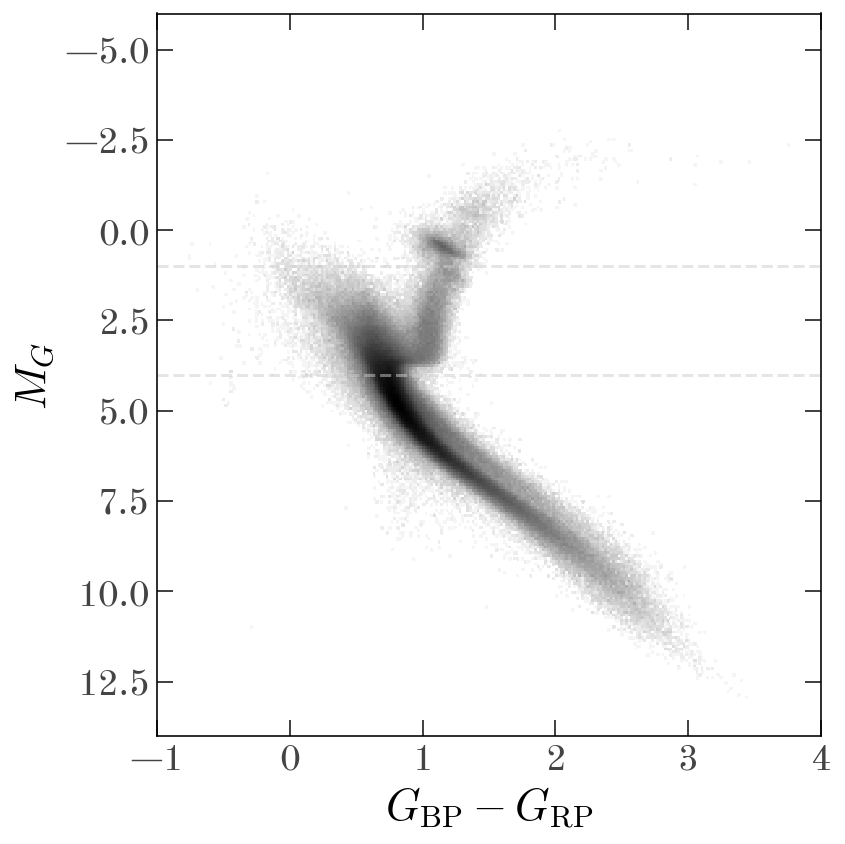

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

bins = (np.linspace(-1, 4, 256),
        np.linspace(-6, 14, 256))

ax.hist2d(
    BPRP.value, 
    MG.value,
    bins=bins,
    norm=mpl.colors.LogNorm(),
    cmap='Greys'
)

for lim in MG_lim:
    ax.axhline(lim.value, marker='', color='#cccccc', 
               linestyle='--', alpha=0.5)

ax.set_ylim(14, -6)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

fig.tight_layout()

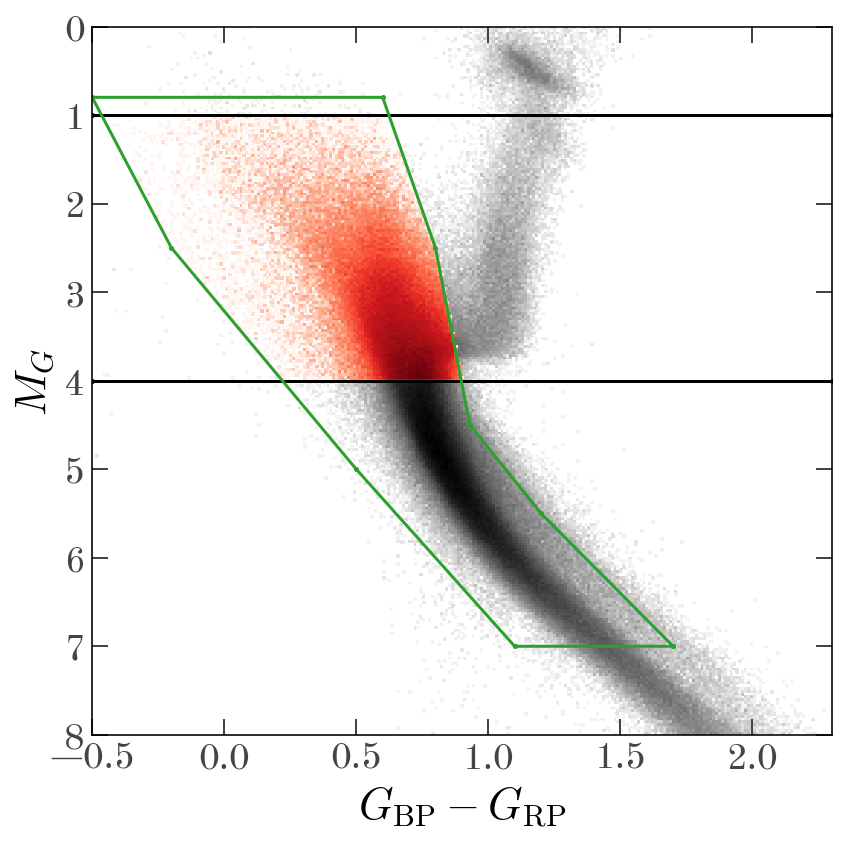

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(
    BPRP.value, 
    MG.value,
    bins=(np.linspace(-0.5, 2.3, 256),
          np.linspace(0, 8, 256)),
    norm=mpl.colors.LogNorm(),
    cmap='Greys'
)

for lim in MG_lim:
    ax.axhline(lim.value)
    
nodes = np.array([
    [1.7, 7],
    [1.1, 7],
    [0.5, 5],
    [-0.2, 2.5],
    [-0.5, 0.8],
    [0.6, 0.8],
    [0.8, 2.5],
    [0.93, 4.5],
    [1.2, 5.5],
    [1.7, 7]
])
ax.plot(nodes[:, 0], nodes[:, 1], color='tab:green')
path_ = mpl.path.Path(nodes)
cmd_mask = (
    path_.contains_points(np.stack((BPRP.value, MG.value)).T) &
    (MG > MG_lim[0]) &
    (MG < MG_lim[1])
)

ax.hist2d(
    BPRP.value[cmd_mask], 
    MG.value[cmd_mask],
    bins=(np.linspace(-0.5, 2.3, 256),
          np.linspace(0, 8, 256)),
    norm=mpl.colors.LogNorm(),
    cmap='Reds'
)

ax.set_ylim(8, 0)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')
fig.tight_layout()

In [11]:
cmd_mask.sum()

166376

In [12]:
ms_g = g[cmd_mask]
plx_snr = (ms_g.parallax / ms_g.parallax_error).decompose().value
(ms_g.ruwe < 1.4).sum() / len(ms_g), (plx_snr > 10).sum() / len(ms_g)

(0.8523525027648219, 0.9896980333701976)

In [13]:
np.isfinite(ms_g.dr2_radial_velocity).sum() / len(ms_g)

0.25711641102082033

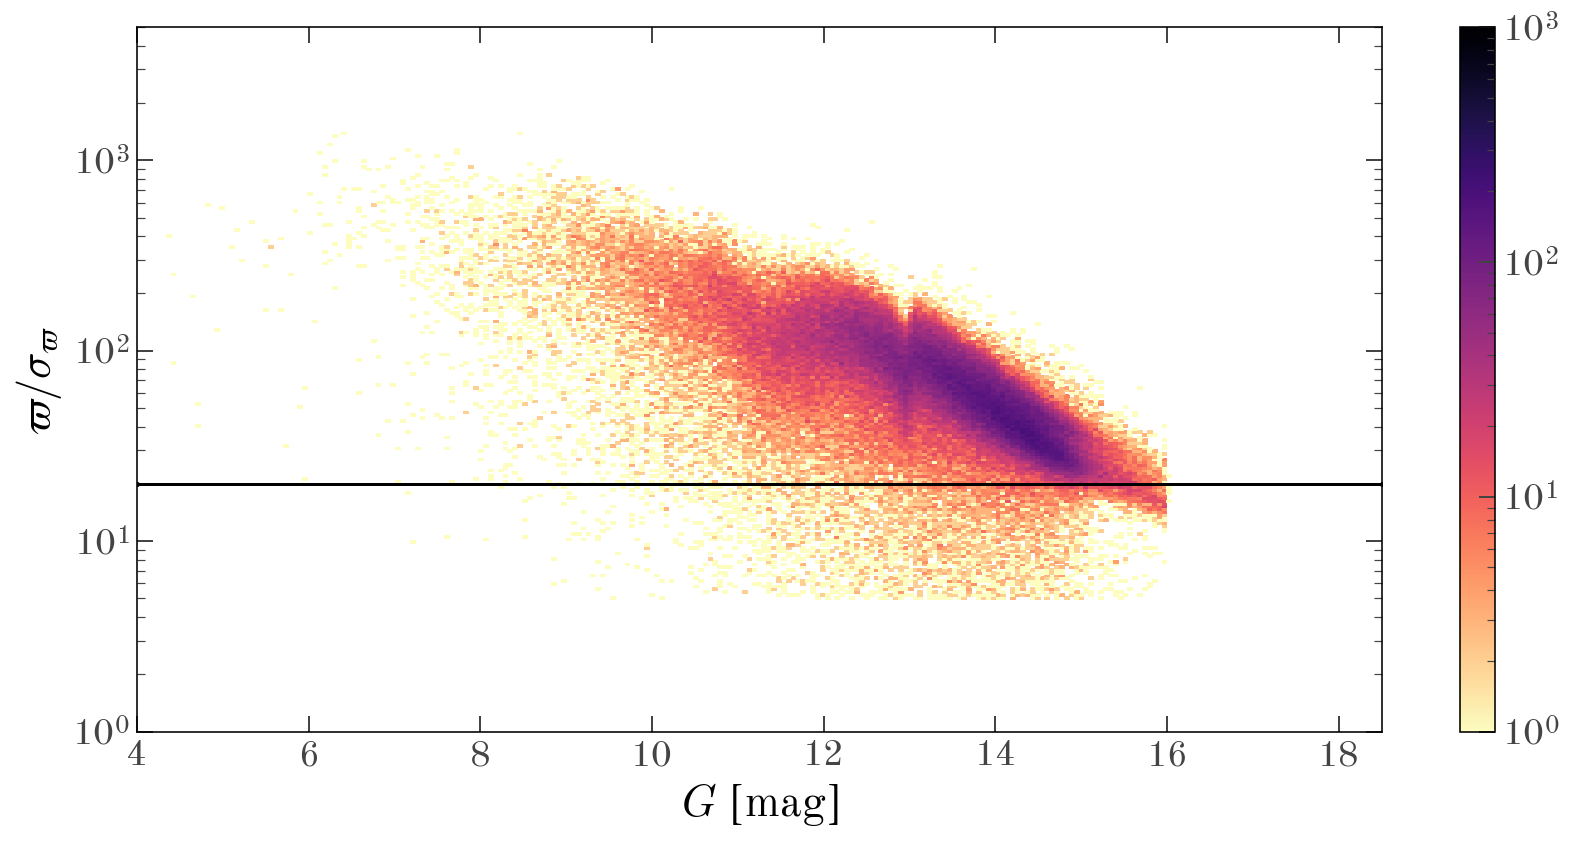

In [14]:
plt.figure(figsize=(12, 6))
plt.hist2d(
    ms_g.phot_g_mean_mag.value, 
    plx_snr,
    bins=(np.linspace(4, 18.5, 256),
          np.geomspace(1, 5e3, 256)),
    norm=mpl.colors.LogNorm(vmin=1, vmax=1e3),
    cmap='magma_r'
)
plt.axhline(20.)
plt.colorbar()
plt.yscale('log')
plt.xlabel('$G$ [mag]')
plt.ylabel(r'$\varpi / \sigma_\varpi$')
plt.tight_layout()

In [15]:
gal = ms_g.skycoord.galactic
gal_xyz = gal.represent_as('cartesian').xyz
gal_xyz_kpc = gal_xyz.to_value(u.kpc)

Sky distribution / uniformity of sample:

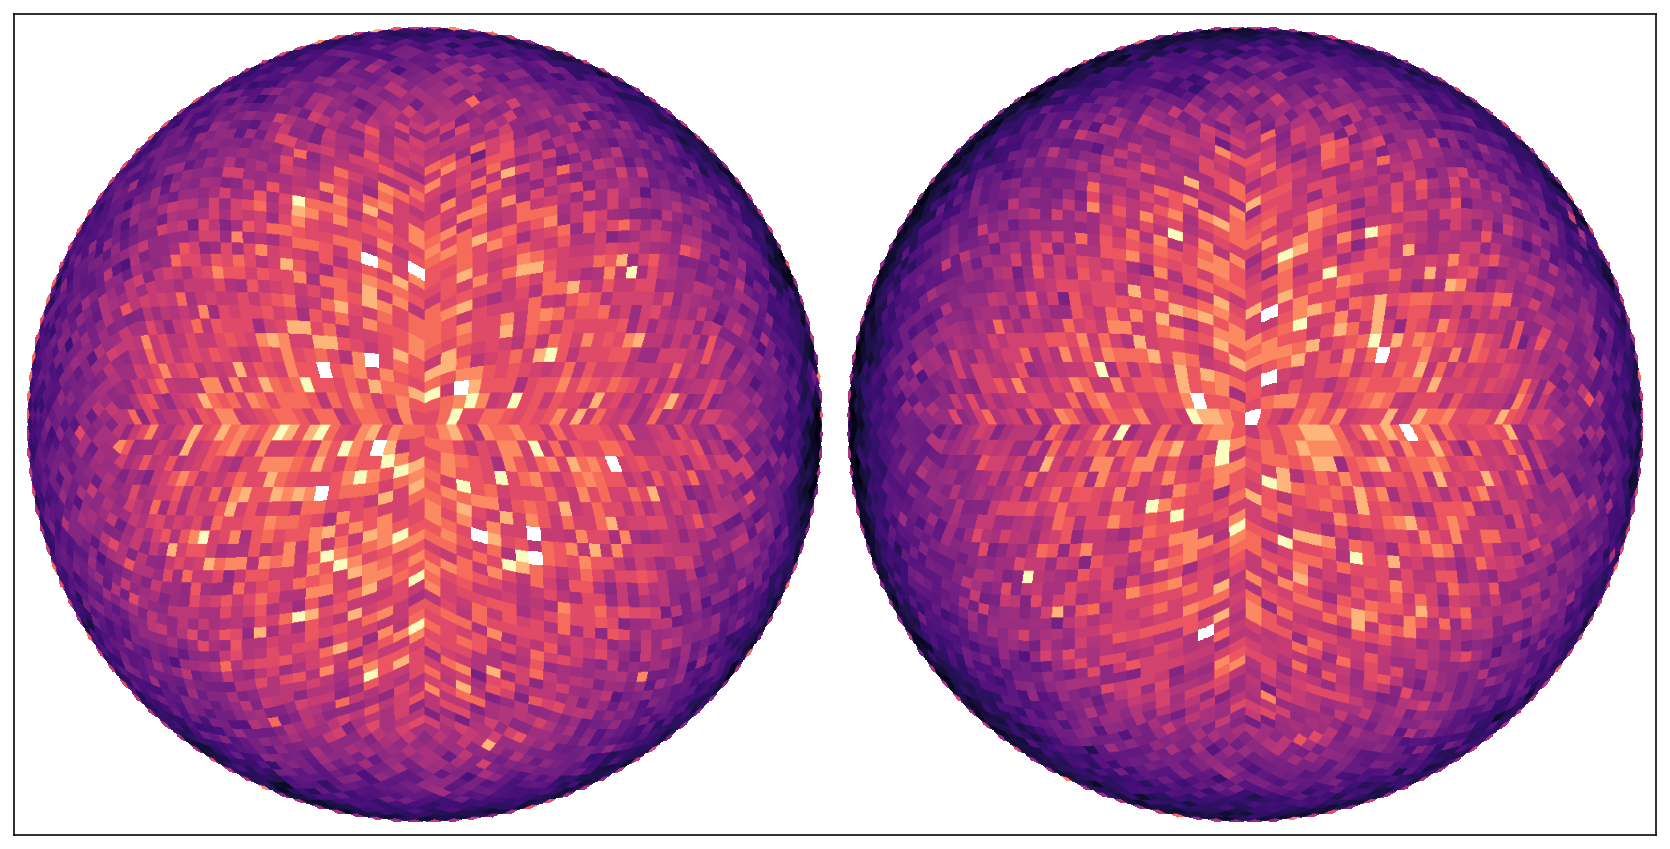

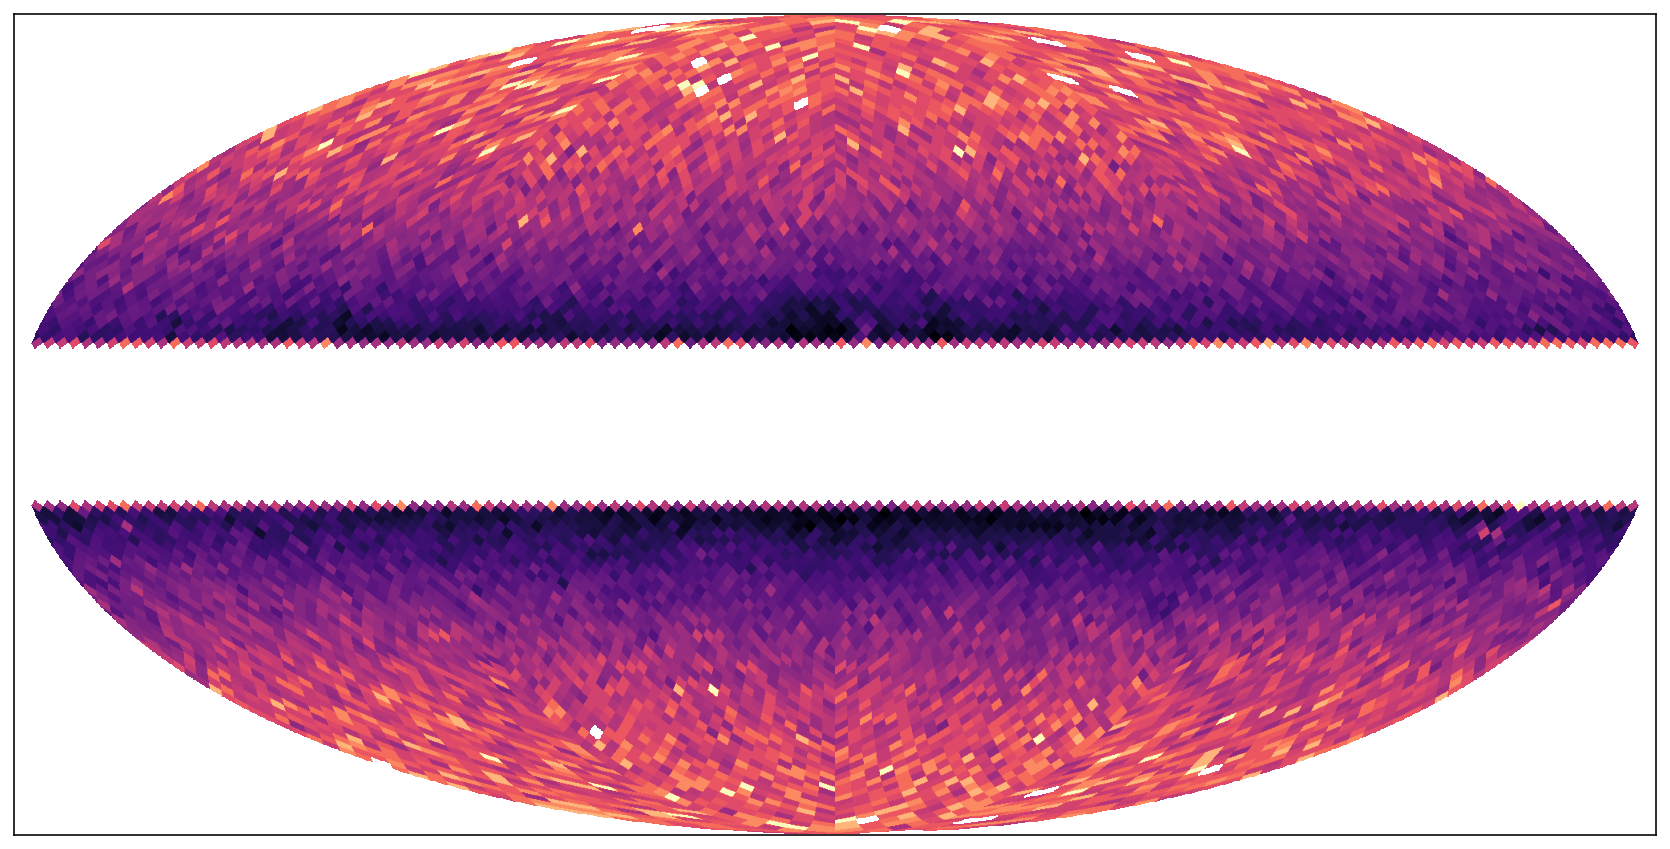

In [16]:
nside = 32
npix = hp.nside2npix(nside)

indices = hp.ang2pix(
    nside, 
    gal.spherical.lon.to_value(u.degree),
    gal.spherical.lat.to_value(u.degree),
    lonlat=True
)

hpxmap = np.zeros(npix, dtype=np.int32)  # int64 if you have a lot of sources!
np.add.at(hpxmap, indices, 1)

func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

for proj in [hp.projector.OrthographicProj(xsize=2048, rot=[0, 90, 90]),
             hp.projector.MollweideProj(xsize=2048)]:
    img = proj.projmap(hpxmap, func)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(
        img, 
        origin='lower', 
        extent=proj.get_extent(),
        cmap='magma_r',
        norm=mpl.colors.LogNorm()
    )
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.tight_layout()

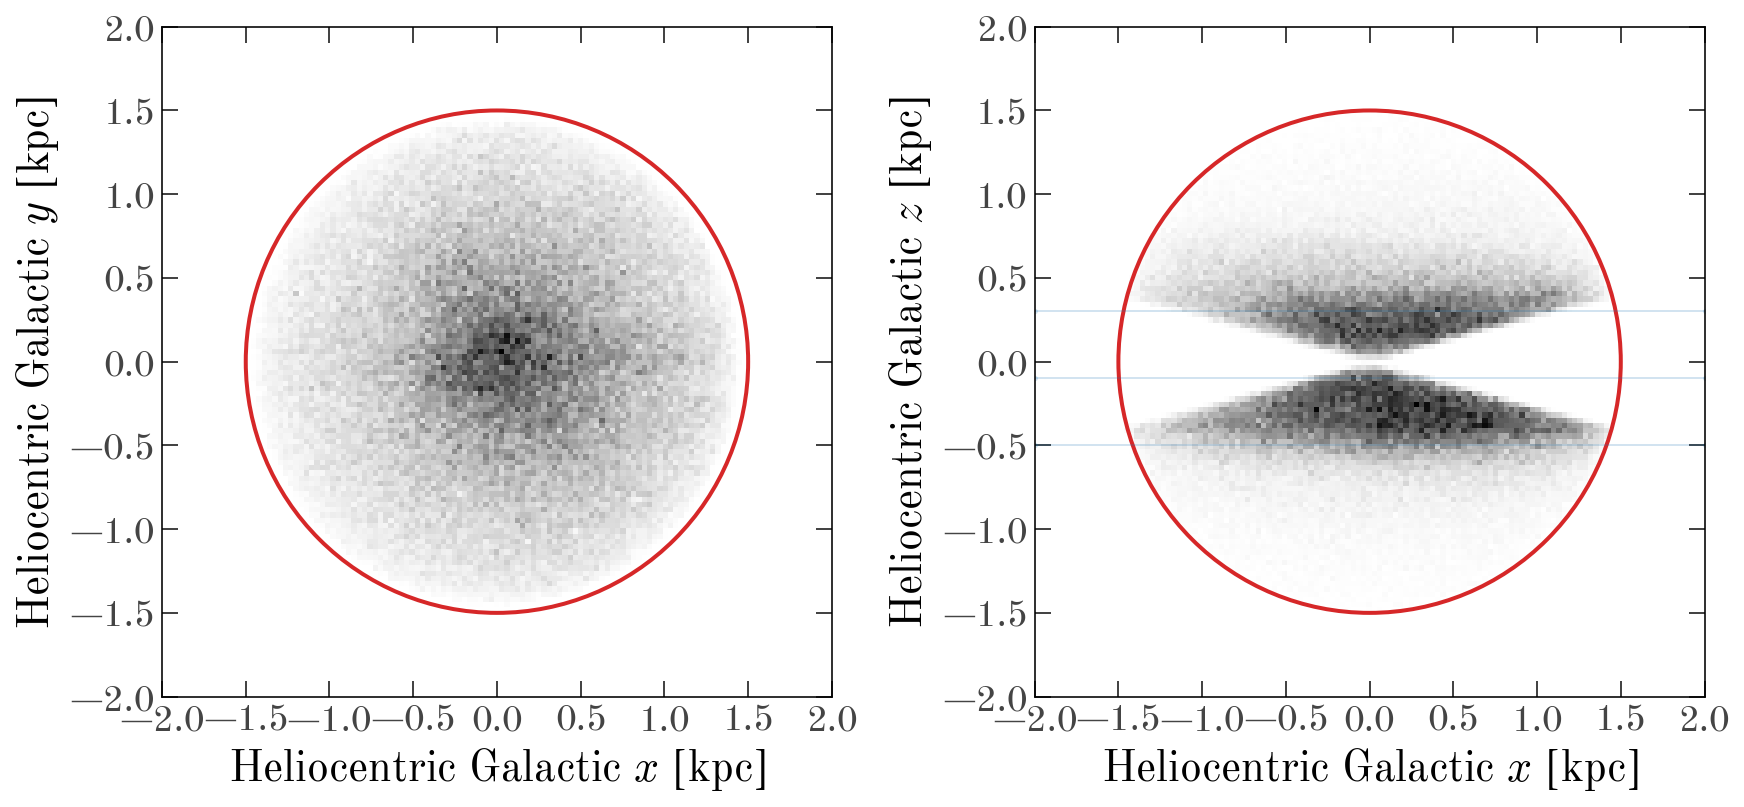

In [17]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(gal_xyz_kpc[0], gal_xyz_kpc[1]), 
                               (gal_xyz_kpc[0], gal_xyz_kpc[2])],
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );
    
shit = -0.1
axes[1].axhline(shit, color='tab:blue', lw=1, alpha=0.2)
axes[1].axhline(shit - 0.4, color='tab:blue', lw=1, alpha=0.2)
axes[1].axhline(shit + 0.4, color='tab:blue', lw=1, alpha=0.2)

Make simulated stars and apply selection:

In [26]:
N = 5_000_000
fiducial = {
    'h1': 120.,
    'h2': 400.,
    'f': 0.75,
    'zsun': -20.8,
    'roll': 0.
}
rng = np.random.default_rng(42)
z_samples = (invt_sample_z(
    ln_two_sech2, 
    size=N,
    args=(fiducial['h1'], fiducial['h2'], fiducial['f']),
    rng=rng
) * u.pc).to(u.kpc)
x_samples = rng.uniform(-1, 1, size=N) * max_dist
y_samples = rng.uniform(-1, 1, size=N) * max_dist
xyz_samples = np.stack((x_samples, y_samples, z_samples), axis=0)

sim_gal = coord.CartesianRepresentation(
    schmagal_to_gal(xyz_samples, 
                    sgrA_sph, fiducial['zsun'] * u.pc, fiducial['roll'] * u.rad)
)
sim_gal_xyz = sim_gal.xyz
sim_gal_xyz_kpc = sim_gal.xyz.to_value(u.kpc)
sim_gal = sim_gal.represent_as(coord.SphericalRepresentation)
sim_mask = (
    (np.abs(sim_gal.lat) > min_b) &
    (sim_gal.distance < max_dist)
)

In [27]:
# print(gal.distance.min(), sim_gal.distance[sim_mask].min())
print(gal.distance.max(), sim_gal.distance[sim_mask].max())

1499.9705056148173 pc 1.4999984105966748 kpc


In [28]:
RR = np.sqrt(gal_xyz[0]**2 + gal_xyz[1]**2)
sim_RR = np.sqrt(sim_gal_xyz[0]**2 + sim_gal_xyz[1]**2)

_R = 300 * u.pc
_z_min = _R / np.tan(90*u.deg - min_b)
print(_z_min)

shit_mask = (RR < _R) & (np.abs(gal_xyz[2]) > _z_min)
sim_shit_mask = (sim_RR < _R) & (np.abs(sim_gal_xyz[2]) > _z_min)
shit_mask.sum(), len(shit_mask), sim_shit_mask.sum()

80.3847577293368 pc


(14762, 166376, 114674)

(-1.5, 1.5)

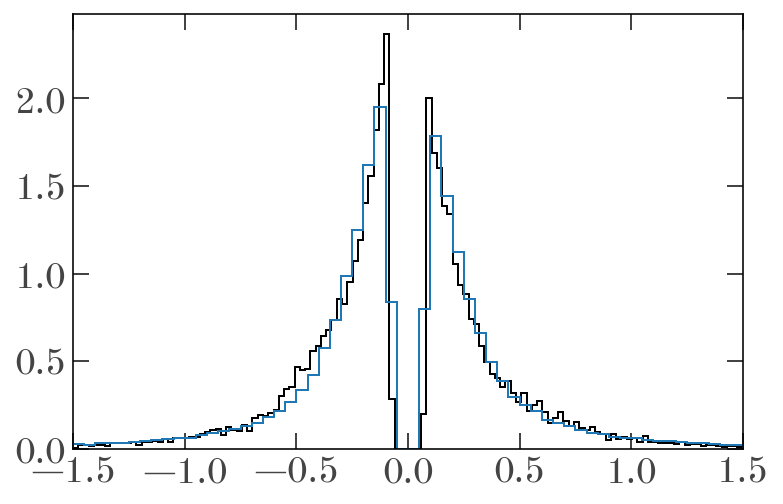

In [31]:
bins = np.linspace(-1.5, 1.5, 128)
plt.hist(gal_xyz_kpc[2][shit_mask], bins=bins, density=True, histtype='step');
bins = np.linspace(bins.min(), bins.max(), 61)
plt.hist(sim_gal_xyz_kpc[2][sim_shit_mask], density=True, bins=bins, histtype='step');
plt.xlim(-1.5, 1.5)

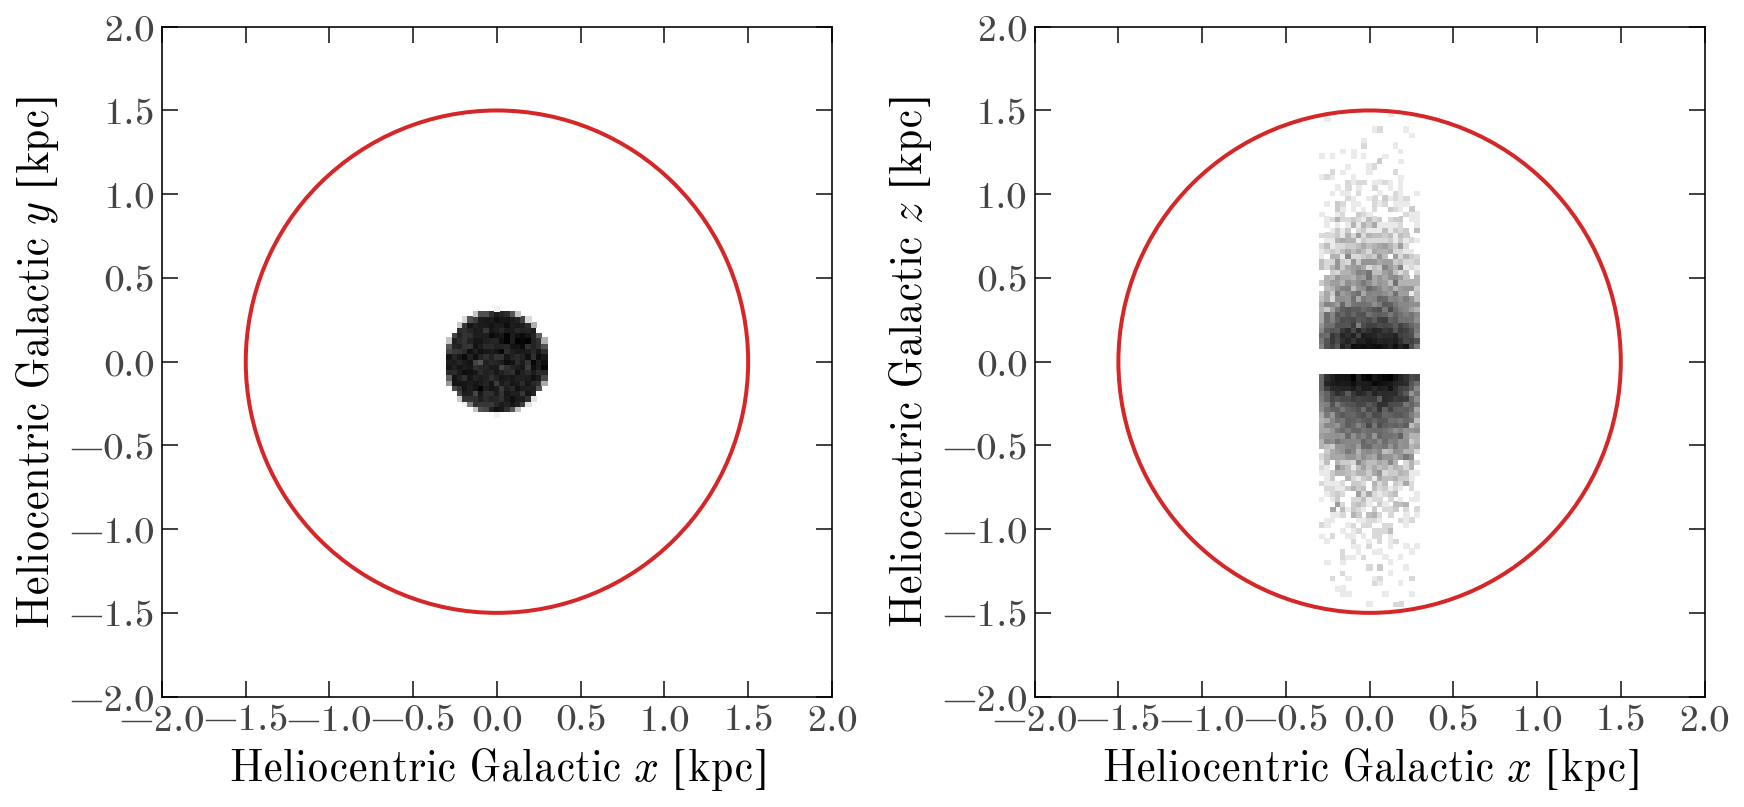

In [32]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(gal_xyz_kpc[0], gal_xyz_kpc[1]), 
                               (gal_xyz_kpc[0], gal_xyz_kpc[2])],
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0][shit_mask], 
        coords[1][shit_mask], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys',
        norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

(-1.5, 1.5)

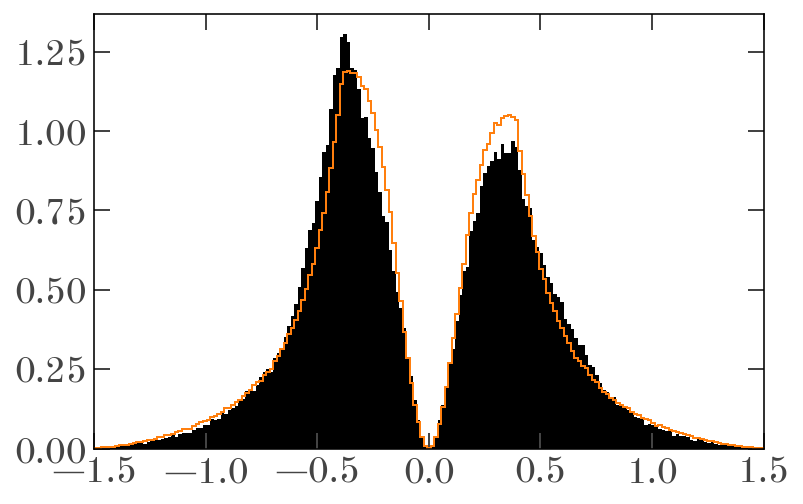

In [33]:
bins = np.linspace(-2, 2, 256)
plt.hist(gal_xyz_kpc[2], bins=bins, density=True);
plt.hist(sim_gal_xyz[2].to_value(u.kpc)[sim_mask], 
         color='tab:orange', bins=bins, histtype='step',
         density=True);
# plt.yscale('log')
plt.xlim(-1.5, 1.5)

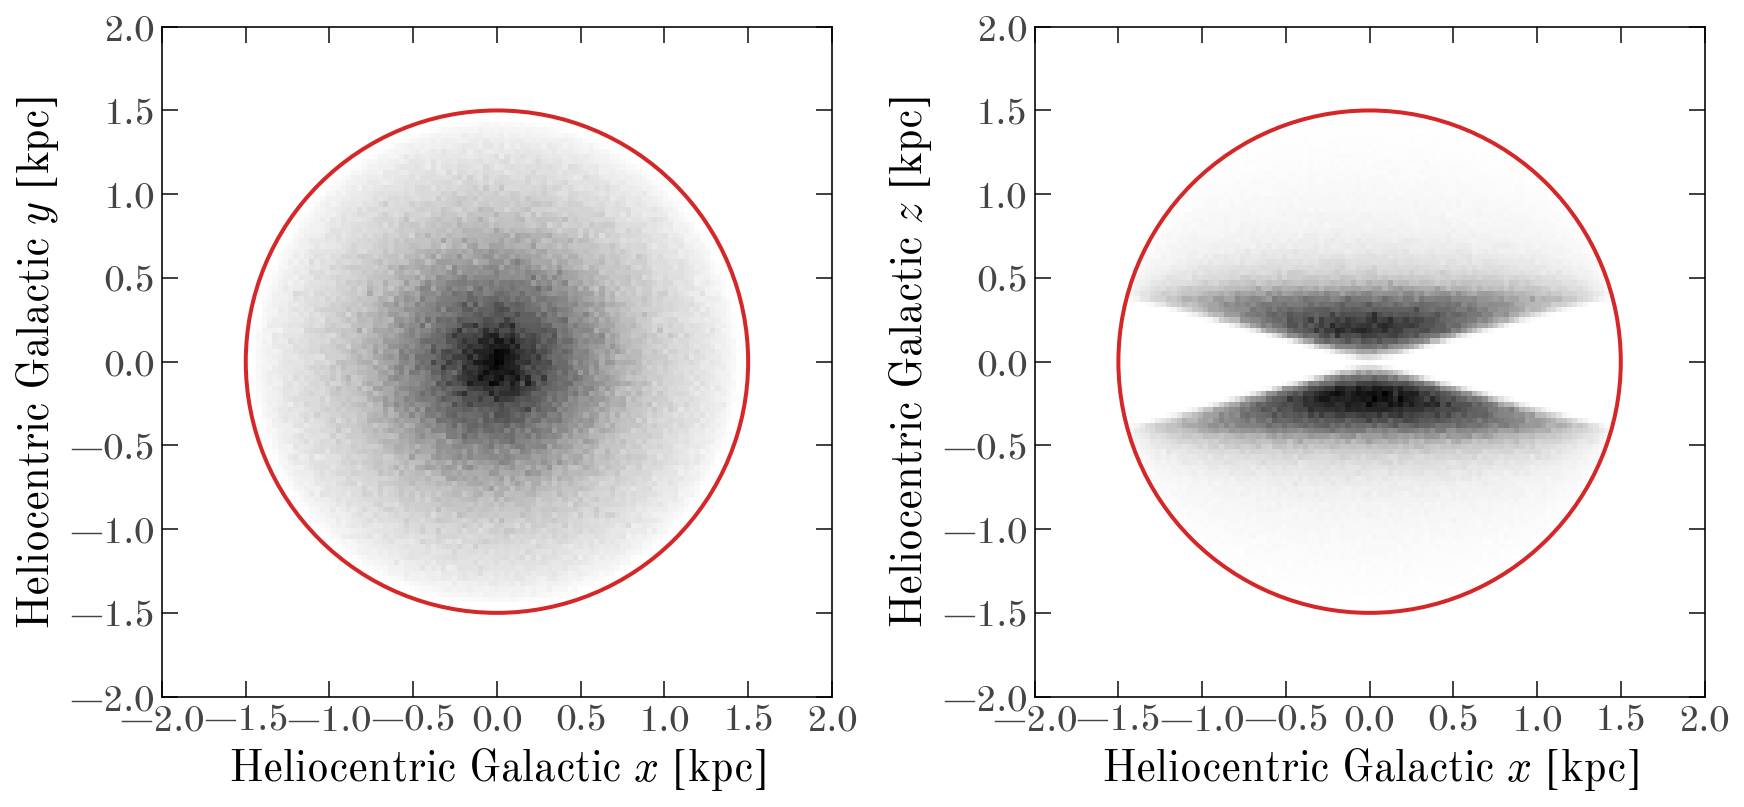

In [34]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
sim_xyz = sim_gal.to_cartesian()[sim_mask].xyz.value
for ax, coords, labels in zip(axes, 
                              [[sim_xyz[0], sim_xyz[1]],
                               [sim_xyz[0], sim_xyz[2]]],
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

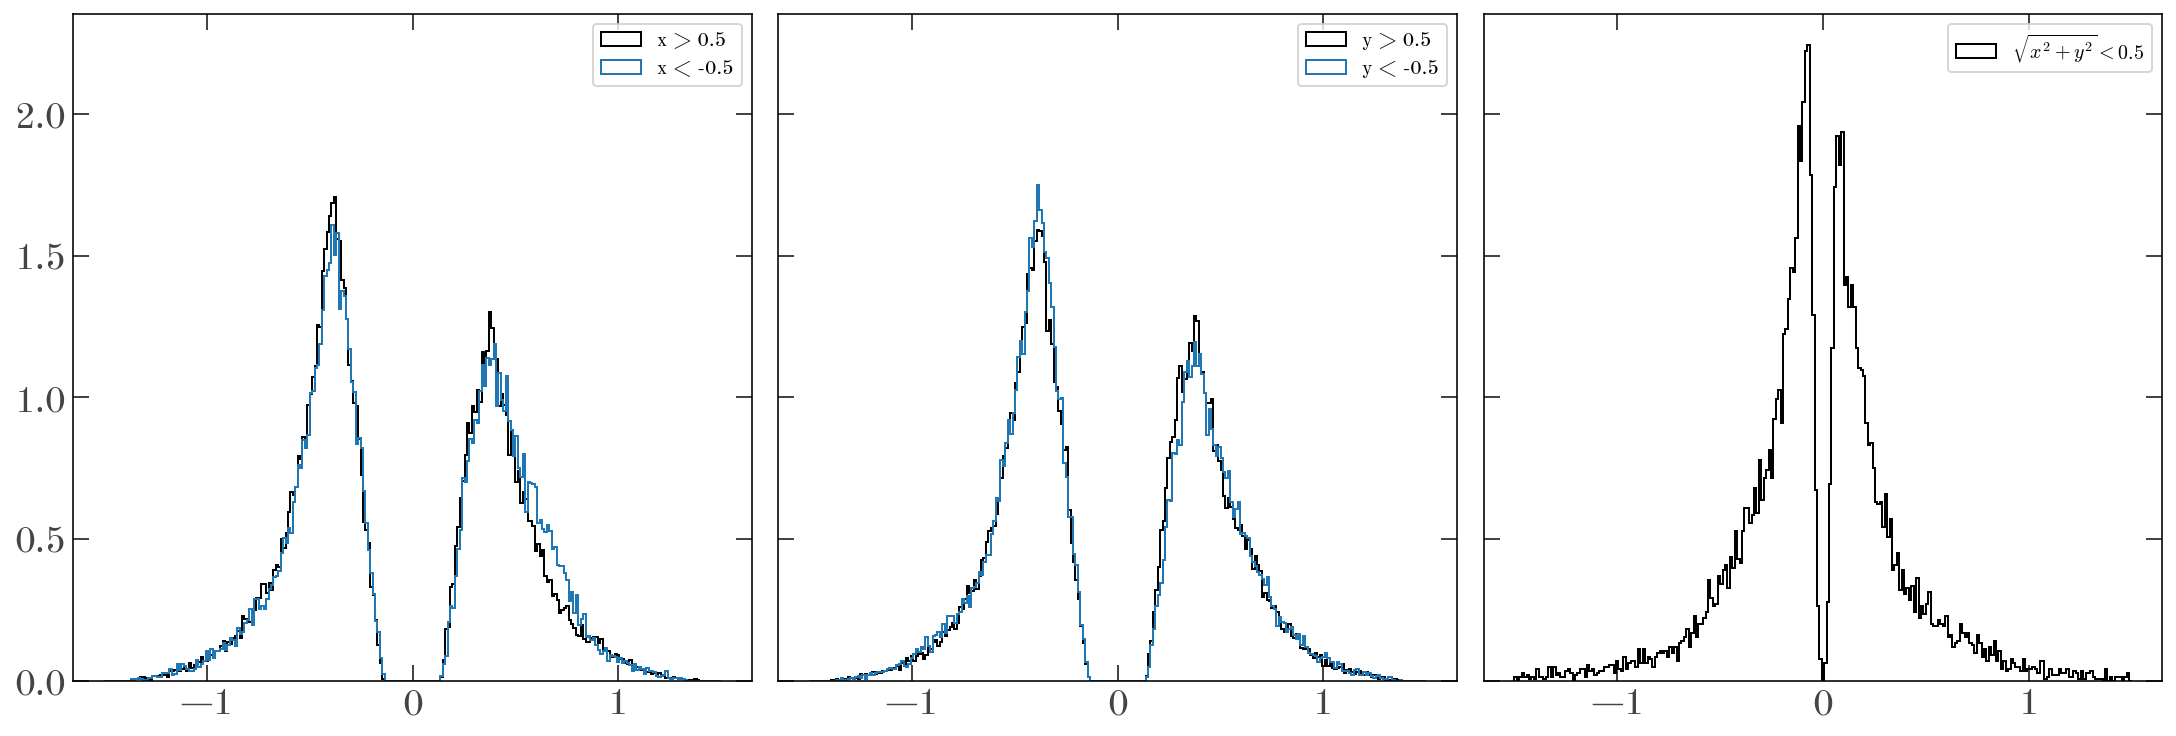

In [35]:
kw = dict(bins=np.linspace(-1.5, 1.5, 256), density=True, histtype='step')

fig, axes = plt.subplots(1, 3, figsize=(15, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

axes[0].hist(gal_xyz_kpc[2][gal_xyz_kpc[0] > 0.5], label='x > 0.5', **kw)
axes[0].hist(gal_xyz_kpc[2][gal_xyz_kpc[0] < -0.5], label='x < -0.5', **kw);
axes[0].legend()

axes[1].hist(gal_xyz_kpc[2][gal_xyz_kpc[1] > 0.5], label='y > 0.5', **kw)
axes[1].hist(gal_xyz_kpc[2][gal_xyz_kpc[1] < -0.5], label='y < -0.5', **kw);
axes[1].legend()

axes[2].hist(gal_xyz_kpc[2][np.sqrt(gal_xyz_kpc[0]**2 + gal_xyz_kpc[1]**2) < 0.25], 
             label=r'$\sqrt{x^2 + y^2} < 0.5$', **kw)
axes[2].legend()

TODO: figure out how to deal with uniform density??

In [37]:
x_args = (-max_dist.to_value(u.pc), max_dist.to_value(u.pc))
y_args = (-max_dist.to_value(u.pc), max_dist.to_value(u.pc))
z_args = (fiducial['h1'], fiducial['h2'], fiducial['f'])
gal_args = (sgrA_sph, fiducial['zsun'] * u.pc, fiducial['roll'])

ln_density_args = (
    ln_uniform, x_args,
    ln_uniform, y_args,
    ln_two_sech2, z_args,
)

ln_integrand(
    0.,
    (31*u.deg).decompose(usys).value,
    (100*u.pc).decompose(usys).value,
    ln_density_args,
    gal_args
)

-13.40506130222933

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:50: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-2039581.2343235519

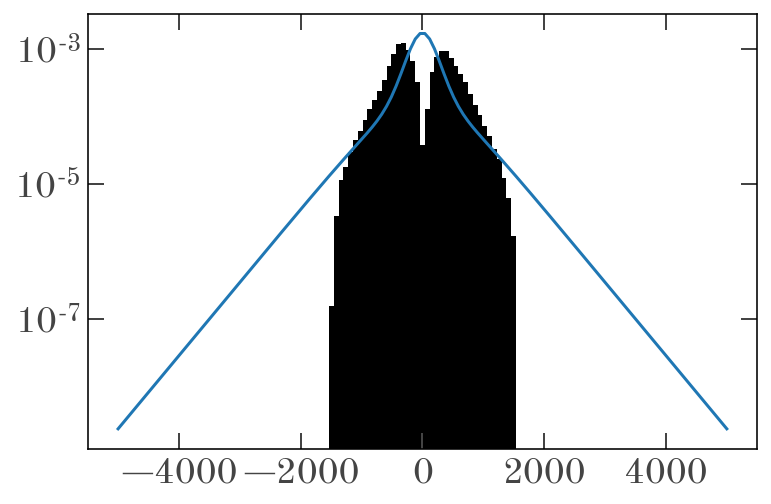

In [38]:
p0 = (
    np.log(gal.shape[0]),
    np.log(fiducial['h1']), 
    np.log(fiducial['h2']),
    fiducial['f'],
    fiducial['zsun'],
    fiducial['roll'],
)
p0_names = (
    'lnn0',
    'lnh1',
    'lnh2',
    'f',
    'zsun',
    'roll'
)
data = gal.cartesian.xyz.decompose(usys).value
like_args = (data, sgrA_sph, ln_density_args, min_b, max_dist)
ln_likelihood(p0, *like_args, plot=True)

In [39]:
all_vals = np.linspace(0.75, 1.25, 15)[None] * np.array(p0)[:, None]
all_vals[-1] = np.linspace(-0.3, 0.3, all_vals[-1].size) # roll

all_lls = []
for i in range(len(p0)):
    print(i)
    this_p0 = np.array(p0, copy=True)
    lls = []
    vals = all_vals[i]
    for j, val in enumerate(vals):
        print(f"{j+1}/{len(vals)}", end="\r")
        this_p0[i] = val
        lls.append(ln_likelihood(this_p0, *like_args))
    all_lls.append(lls)
all_lls = np.array(all_lls)

0
15/15
25/15
35/15
45/15
55/15


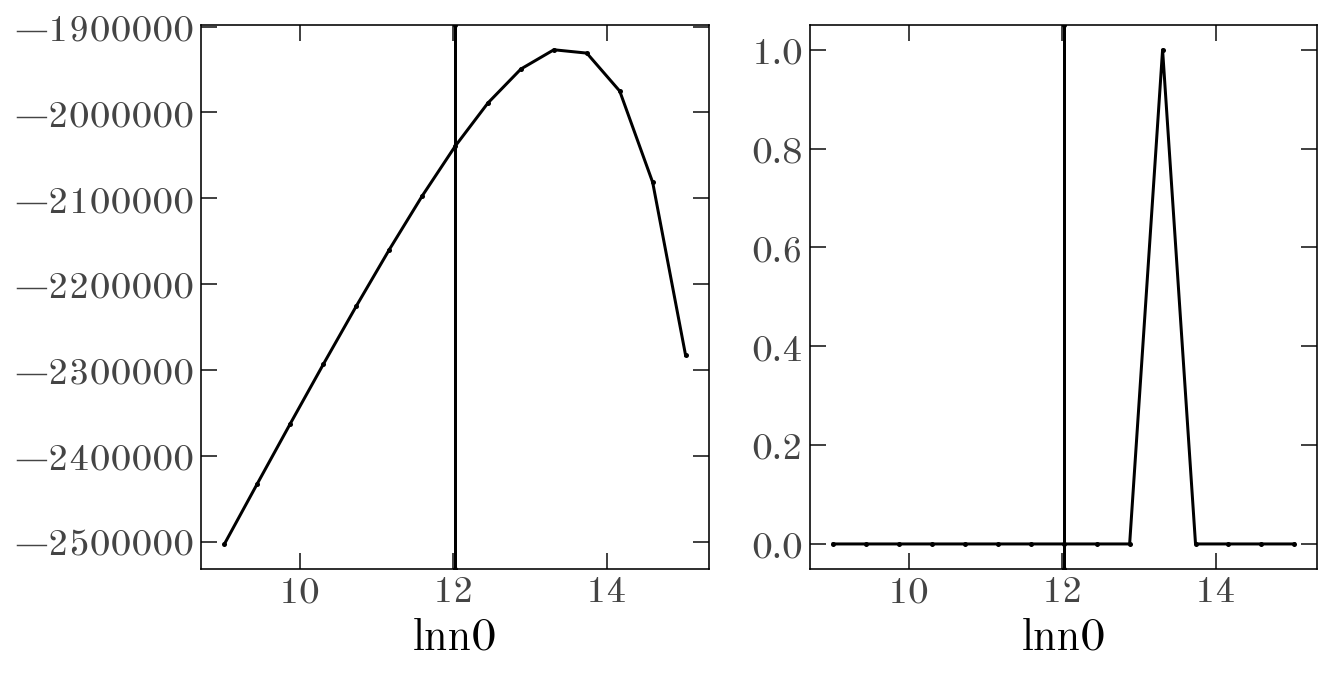

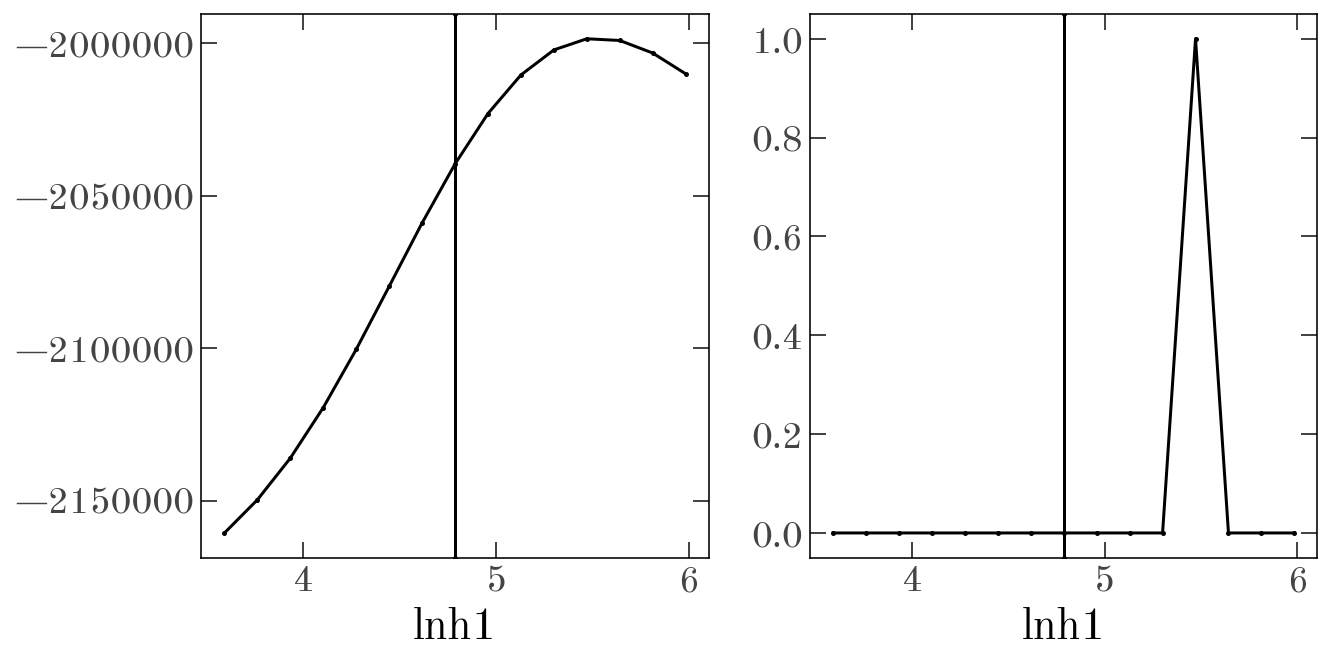

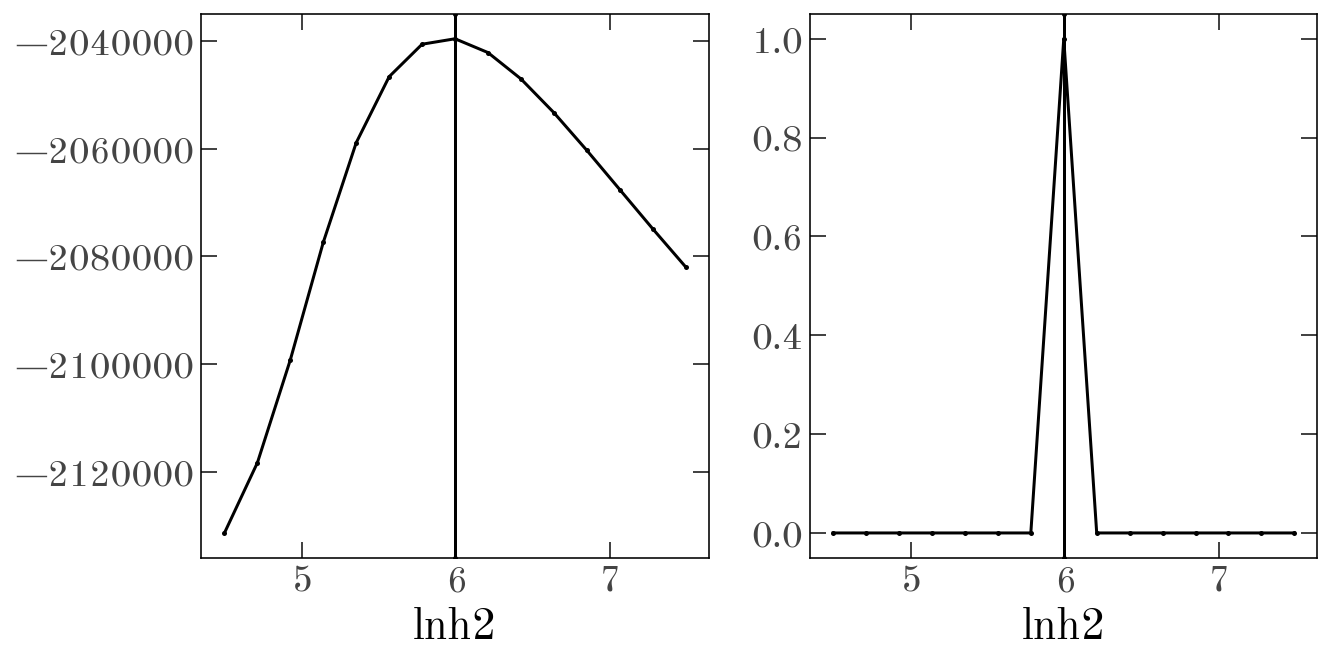

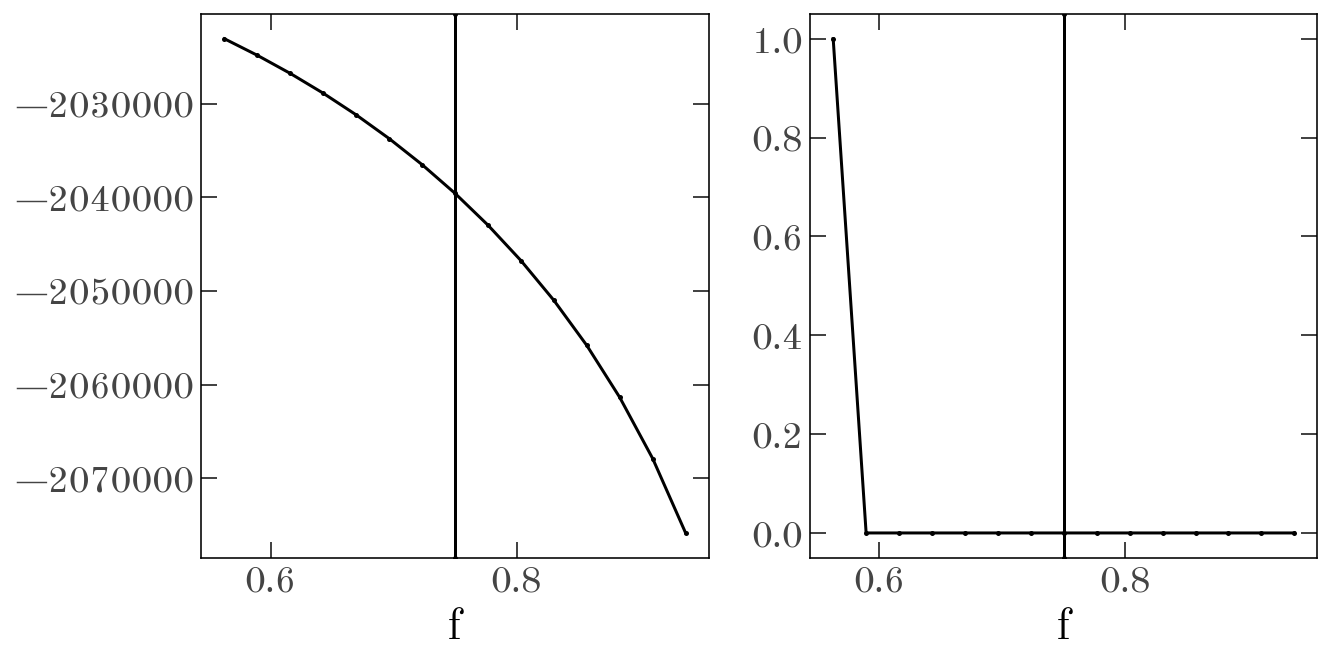

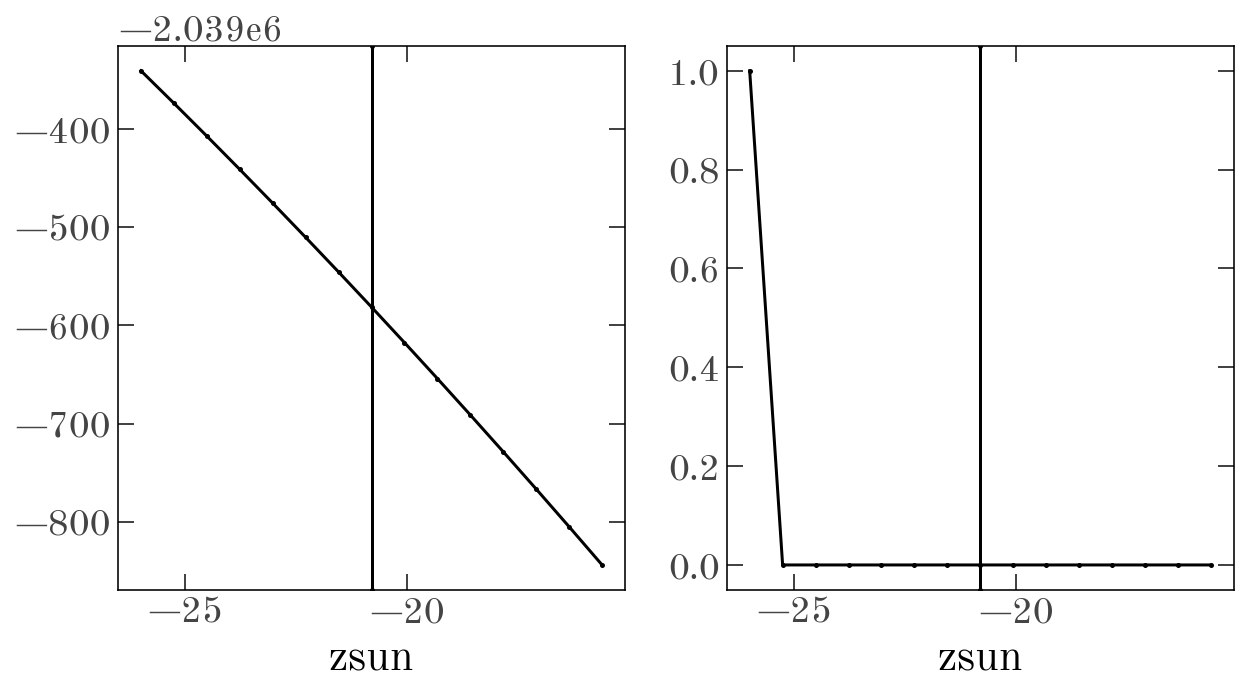

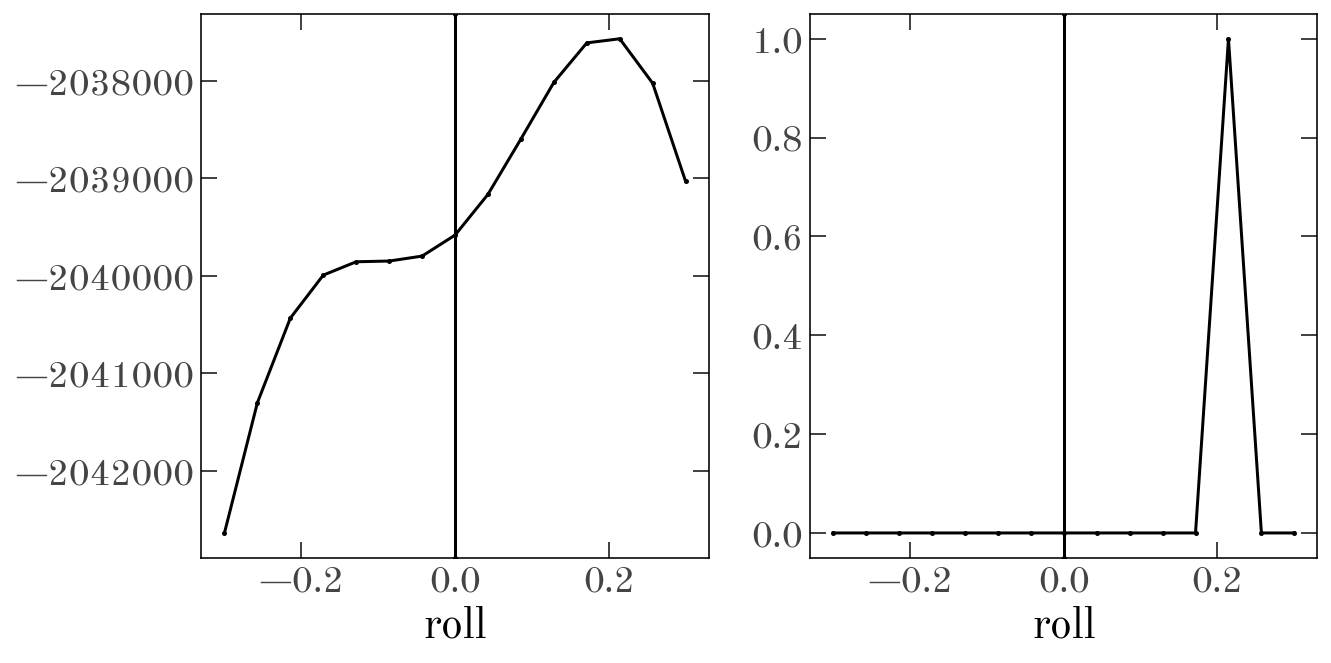

In [40]:
for i in range(all_lls.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(all_vals[i], all_lls[i])
    axes[1].plot(all_vals[i], np.exp(all_lls[i] - all_lls[i].max()))
    for ax in axes:
        ax.set_xlabel(p0_names[i])
        ax.axvline(p0[i])

In [54]:
full_res = minimize(
    lambda *args: -ln_likelihood(*args), 
    x0=p0, 
    args=like_args, 
    method='nelder-mead'
)

/mnt/ceph/users/apricewhelan/projects/solar-velocity/notebooks/model_helpers.py:50: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))
